**Лекция 9**

# Выбор ковариационной функции и её параметров

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Влияние-вида-ковариационной-функции" data-toc-modified-id="Влияние-вида-ковариационной-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Влияние вида ковариационной функции</a></span><ul class="toc-item"><li><span><a href="#Используемые-ковариационный-функции" data-toc-modified-id="Используемые-ковариационный-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Используемые ковариационный функции</a></span></li><li><span><a href="#Обучающие-данные" data-toc-modified-id="Обучающие-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучающие данные</a></span></li></ul></li><li><span><a href="#Влияние-параметров-ковариационной-функции" data-toc-modified-id="Влияние-параметров-ковариационной-функции-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Влияние параметров ковариационной функции</a></span><ul class="toc-item"><li><span><a href="#Используемые-функции" data-toc-modified-id="Используемые-функции-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Используемые функции</a></span></li><li><span><a href="#Варьирование-параметров-ядра-и-амплитуды-шума" data-toc-modified-id="Варьирование-параметров-ядра-и-амплитуды-шума-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Варьирование параметров ядра и амплитуды шума</a></span></li></ul></li><li><span><a href="#Оптимизация-параметров-ядра" data-toc-modified-id="Оптимизация-параметров-ядра-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оптимизация параметров ядра</a></span><ul class="toc-item"><li><span><a href="#Одномерный-случай" data-toc-modified-id="Одномерный-случай-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Одномерный случай</a></span></li><li><span><a href="#Двумерный-случай" data-toc-modified-id="Двумерный-случай-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Двумерный случай</a></span></li></ul></li><li><span><a href="#Источники" data-toc-modified-id="Источники-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [1]:
# Imports
import numpy as np
import numpy.linalg as LA
np.random.seed(42)
from scipy.optimize import minimize

import sys
sys.path.append('./scripts')
import GP_kernels
from GP_utils import plot_GP, GP_predictor

In [2]:
# Styles, fonts
import matplotlib
matplotlib.rcParams['font.size'] = 12
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm # Colormaps

import seaborn
seaborn.set_style('whitegrid')

from IPython.display import display, Markdown

In [3]:
# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

На прошлом занятии мы научились делать регрессию, используя гауссовские процессы с заданной фиксированной ковариационной функцией.
Однако во многих практических приложениях указать ковариационную функцию может быть затруднительно.
Обычно мы имеем достаточно расплывчатую информацию о свойствах, например, о значении свободных (гипер-) параметров, например, о длинах.
Таким образом, необходимо разработать методы, решающие проблему выбора модели и значений гиперпараметров.

## Влияние вида ковариационной функции

### Используемые ковариационный функции

Рассмотрим следующие ковариационные функции:

1. Функция Гаусса (квадратичная экспоненциальная функция)
$$
  k(x, x') = \sigma_k^2 \exp \left( -\frac{\lVert x - x' \rVert^2}{2\ell^2}  \right)
$$
1. Рациональная квадратичная функция
$$
  k(x, x') = \sigma_k^2 \left( 1 + \frac{ \left\Vert x - x' \right\Vert^2}{2 \alpha \ell^2} \right)^{-\alpha}
$$
1. Периодическая функция
$$
  k(x, x') = \sigma_k^2 \exp \left(-\frac{2}{\ell^2}\sin^2 \left( \pi \frac{\left\Vert x - x' \right\Vert}{p}\right) \right)
$$

In [4]:
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0.]])
kernels = [GP_kernels.gauss, GP_kernels.rational_quadratic]
kernel_args = [
    (1.0, 1.0, 1e6),
    (0.5, 1.0, 1.0),
    (1.0, 0.5, 0.1),
]

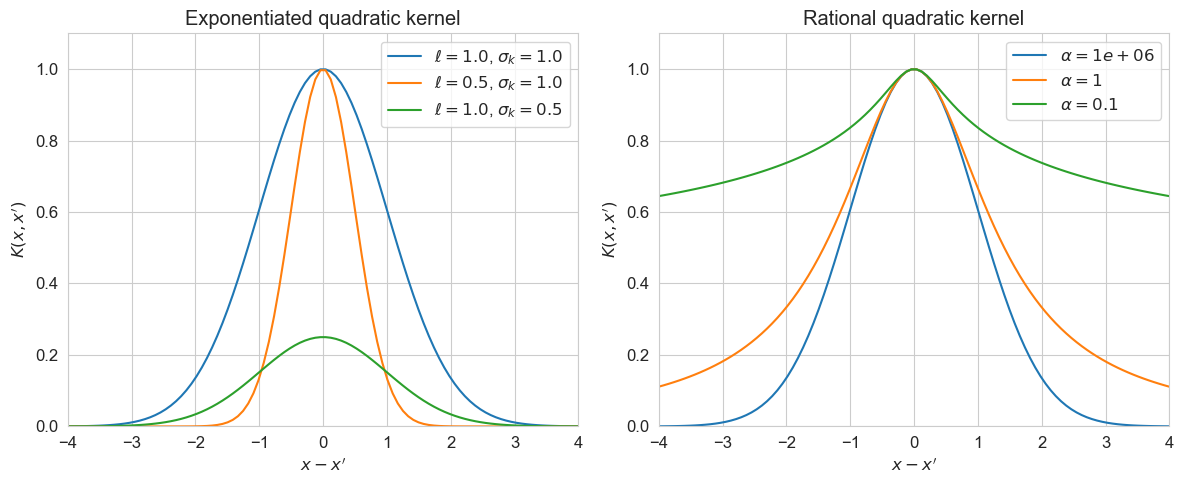

In [5]:
# Plot exponentiated quadratic distance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, kernel in enumerate(kernels):
    for (l, sigma_k, alpha) in kernel_args:
        if 'gauss' in str(kernel):
            axes[i].set_title('Exponentiated quadratic kernel')
            kernel_arg = {'l':l, 'sigma_k':sigma_k}
            label = f'$\\ell = {l}$, $\\sigma_k = {sigma_k}$'
        else:
            axes[i].set_title('Rational quadratic kernel')
            kernel_arg = {'alpha':alpha}
            label = f'$\\alpha = {alpha:g}$'
        K = kernel(zero, X, kernel_arg)
        axes[i].plot(X[:,0], K[0,:], label=label)

    axes[i].set_xlabel('$x - x\'$')
    axes[i].set_ylabel('$K(x,x\')$')
    axes[i].set_ylim([0, 1.1])
    axes[i].set_xlim(*xlim)
    axes[i].legend(loc=1)

plt.tight_layout()
plt.show()

### Обучающие данные

В качестве обучающей выборки будем использовать данные из предыдущего занятия.

In [6]:
# Data
xlim = [0., 10.]
N_test = 501
X_test = np.linspace(*xlim, N_test).reshape(-1, 1)

X_train = np.array([2.,  6.,  7., 8.,  4., 3. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1., 0.5]).reshape(-1, 1)

In [7]:
def plot_regression(ax, X_test, mu, cov, X_train=None, Y_train=None):
    '''Plot samples'''
    X_test = X_test.flatten()
    mu = mu.flatten()
    std = np.sqrt(np.diag(cov))
    
    for std_i in np.linspace(2*std,0,21):
        ax.fill_between(X_test, mu-std_i, mu+std_i,
                        color=cm.tab10(4), alpha=0.02)
    ax.plot(X_test, mu, 'k')
    if X_train is not None:
        ax.plot(X_train, Y_train, 'kx', mew=1.0)
        
    ax.set_xlim([X_test.min(), X_test.max()])
    ax.set_ylim([(mu-3*std).min(), (mu+3*std).max()] )
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True)

In [8]:
def plot_matrix (ax, cov):
    '''Plot covariance matrix'''
    seaborn.set_style('white')
    im = ax.imshow(cov, cmap=cm.YlGnBu)
    cbar = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.05)
    cbar.ax.set_ylabel('$k(X,X)$', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    seaborn.set_style('whitegrid')

Рассмотрим четыре ковариационных функции.

In [9]:
kernels = [ GP_kernels.gauss, GP_kernels.brownian,
            GP_kernels.rational_quadratic, GP_kernels.periodic ]
kernel_names = ['Gauss kernel', 'Brownian kernel',
                'Rational quadratic kernel', 'Periodic kernel']
kernel_args = {'l':1., 'sigma_k':1., 'alpha':0.1, 'period':5.}
sigma_n = 1e-6

In [10]:
def make_kernel_title(kernel_number):
    '''Make title for kernel plot'''
    label  = kernel_names[kernel_number]
    label += f": $\\ell = {kernel_args['l']:.2}$"
    label += f"$,\;\\sigma_k = {kernel_args['sigma_k']:.2}$"
    if kernel_names[i] == 'Rational quadratic kernel':
        label += f"$,\;\\alpha = {kernel_args['alpha']:.2}$"
    elif kernel_names[i] == 'Periodic kernel':
        label += f"$,\;period = {kernel_args['period']:.2}$"
    return label

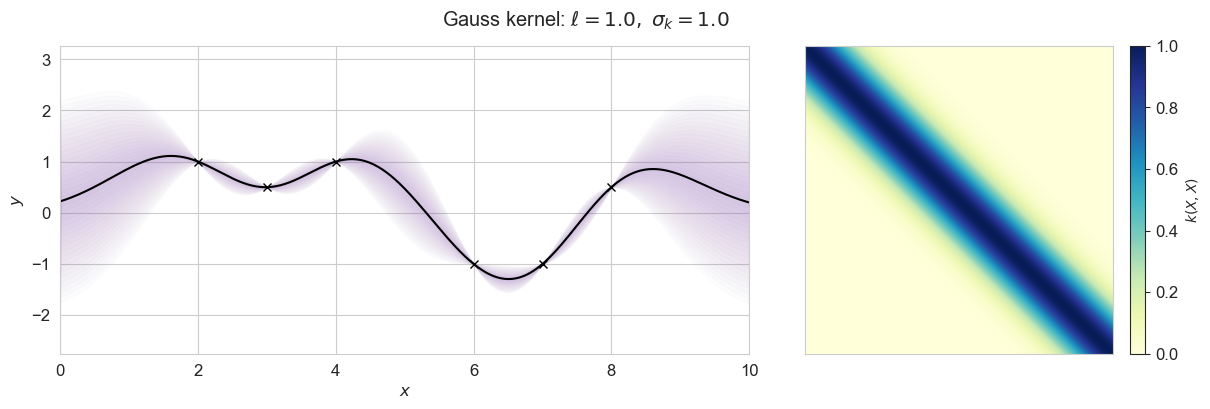

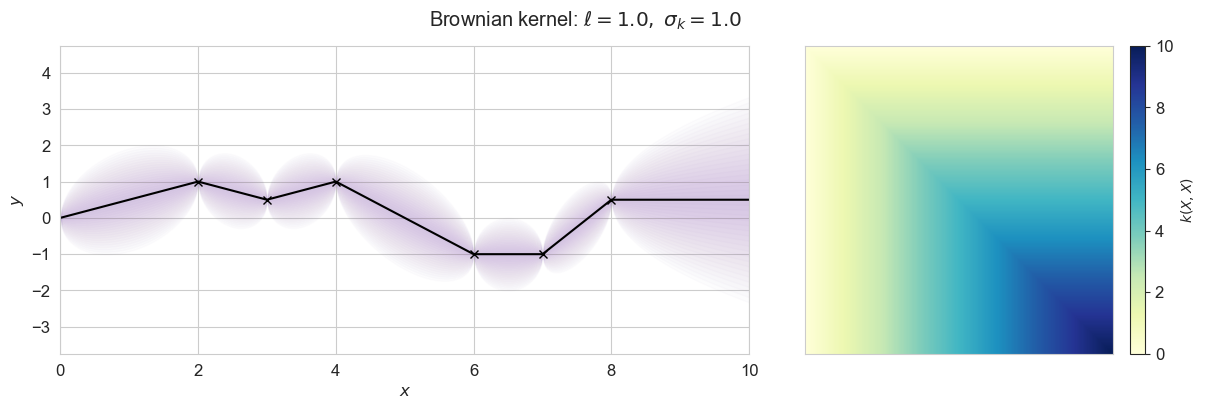

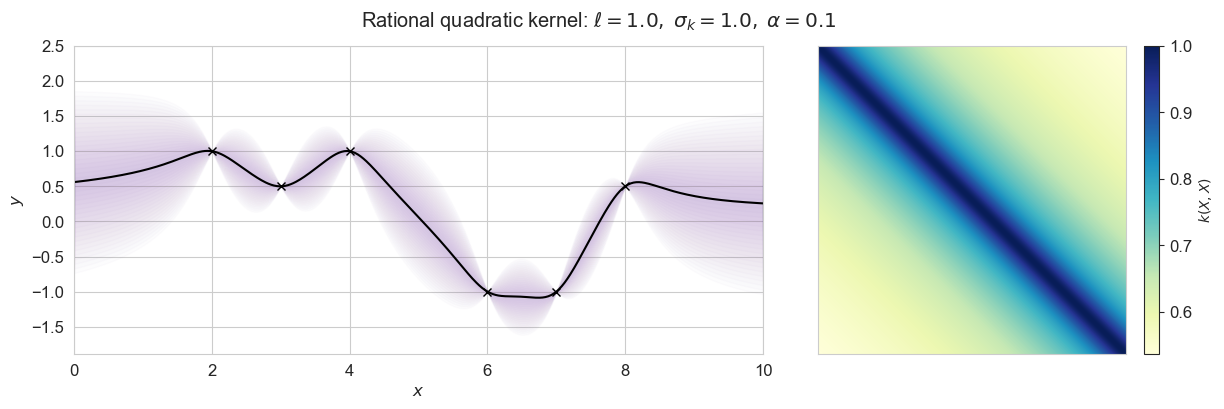

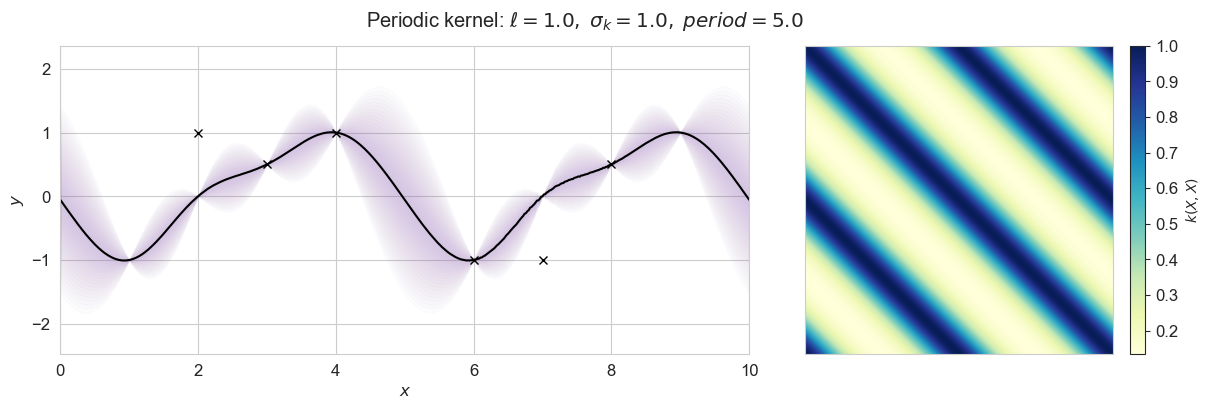

In [11]:
for i, kernel in enumerate(kernels):
    fig = plt.figure(figsize=(14, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,1], wspace=0.1, hspace=0.3)
    # Compute mean and covariance of the posterior predictive distribution
    K = kernel(X_test, X_test, kernel_args)
    mu, cov = GP_predictor(X_test, X_train, Y_train,
                           kernel, kernel_args, sigma_n)
    
    # plot
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    plot_regression(ax1, X_test, mu, cov, X_train, Y_train)
    plot_matrix(ax2, K)
    title = make_kernel_title(i)
    fig.suptitle(title, y=0.97)

    plt.show()

---

## Влияние параметров ковариационной функции

### Используемые функции

На предыдущих занятиях мы использовали квадратичное экспоненциальное ядро:

$$
  k(x, x') = \sigma_k^2 \exp{ \left( -\frac{\lVert x - x' \rVert^2}{2l^2} \right) }.
$$

Теперь пришло время поиграть с параметрами ядра: ширины ядра $l$ и амплитуды $\sigma_f$.

Мы будем использовать функции `gauss()` из `GP_kernels.py`, а также `plot_GP()` и `GP_predictor()` из `GP_utils.py`.

### Варьирование параметров ядра и амплитуды шума

В следующем примере показано влияние параметров ядра $l$ и $\sigma_k$, а также амплитуды шума $\sigma_n$.

In [12]:
params = [
#     (1.0, 1.0, 0.1),
    (0.2, 1.0, 0.1),
    (3.0, 1.0, 0.1),
    (1.0, 0.2, 0.1),
    (1.0, 5.0, 0.1),
    (1.0, 1.0, 1e-6),
    (1.0, 1.0, 2.0),
]

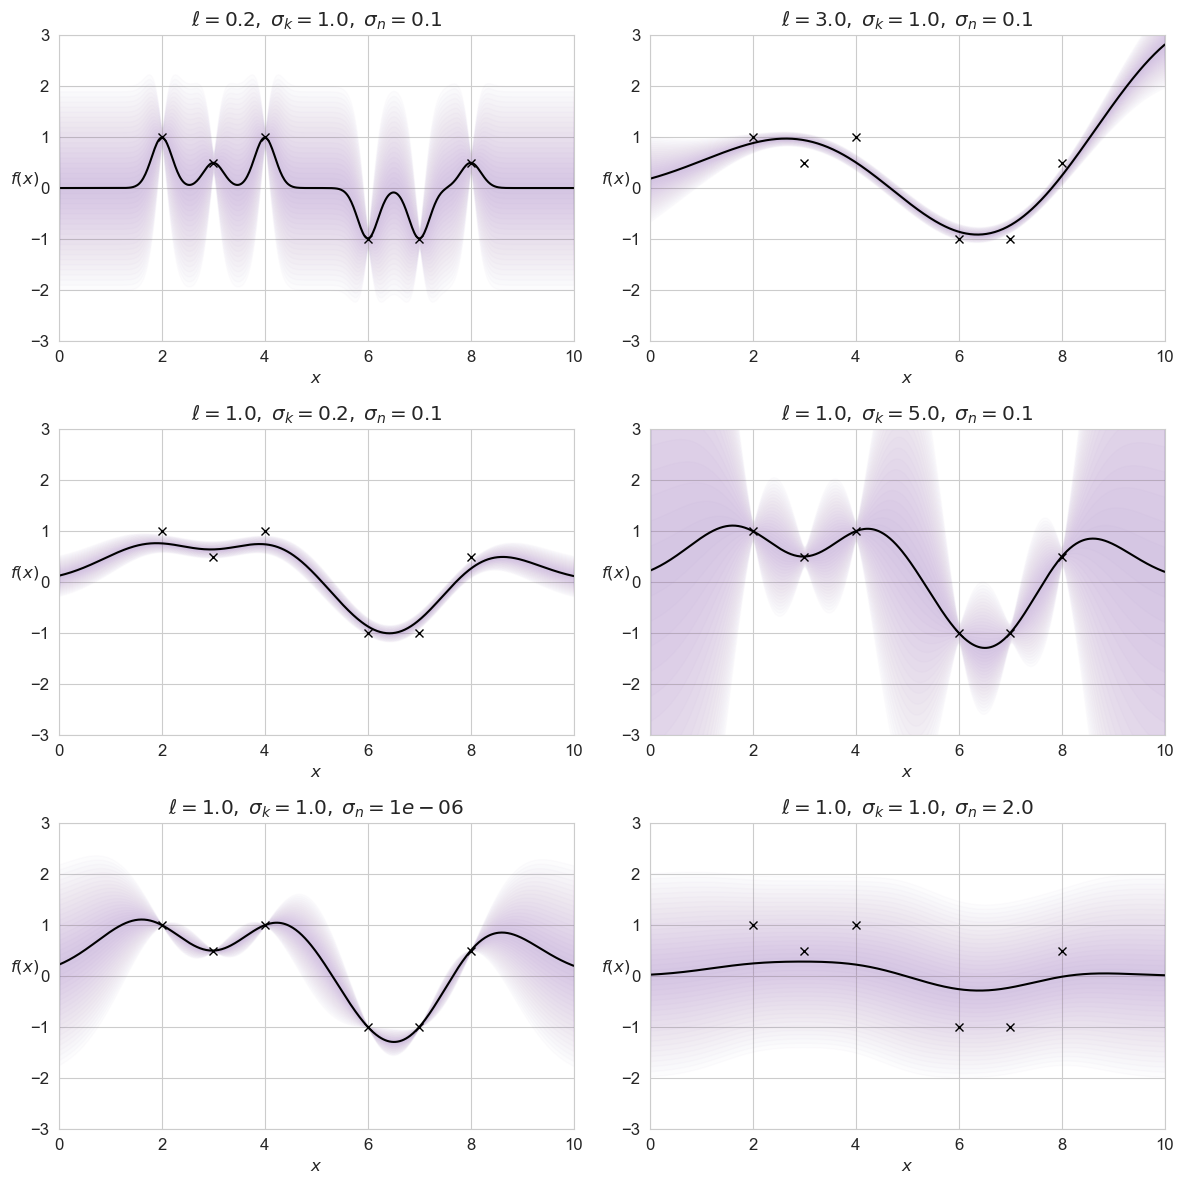

In [13]:
plt.figure(figsize=(12, 12))
y_lim = [-3, 3]

for i, (l, sigma_k, sigma_n) in enumerate(params):
    kernel_fun = GP_kernels.gauss
    kernel_args = {'l':l, 'sigma_k':sigma_k}
    mu, cov = GP_predictor(X_test, X_train, Y_train,
                           kernel_fun, kernel_args, sigma_n)
    
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(top=2)
    plt.title(f'$\ell = {l},\;\sigma_k = {sigma_k},\;\sigma_n = {sigma_n}$')
    plot_GP(X_test, mu, cov, X_train, Y_train, draw_ci=True)
    plt.ylim(y_lim)
    
plt.tight_layout()
plt.show()

По рисункам можно сделать следующие выводы:

1. Малое значения $l$ приводит к достаточно &laquo;изогнутой&raquo; средней функции с большими доверительными интервалами между точками обучающей выборки.
Большое значение ширины ядра $l$ даёт более гладкую регрессионную функцию, но более грубую аппроксимацию обучающих данных.
2. Параметр $\sigma_k$ контролирует вертикальную вариативность функций, взятых из GP.
Это видно по большим доверительным интервалам за пределами области тренировочных данных на правом рисунке второй строки.
3. Параметр $\sigma_n$ представляет собой уровень шума в обучающих данных.
Более высокое значение $\sigma_n$ приводит к более грубой аппроксимации, но позволяет избежать подгонки под шумные данные.

---

## Оптимизация параметров ядра

### Одномерный случай

Мы можем настроить гиперпараметры $\theta$ нашей гауссовской модели процесса на основе полученных данных.
Настройка делается путём максимизации функции правдоподобия $p(Y \mid X, \theta)$ распределения гауссовского процесса на основе данных наблюдений $(X, Y)$.
$$
  \hat{\theta}  = \underset{\theta}{\text{argmax}} \left[ p(Y \mid X, \theta) \right].
$$

Функция правдоподобия гауссовского процесса определяется следующим образом:
$$
  p(y \mid 0, \Sigma) = \mathcal{N}(y \mid 0, \Sigma) = 
  \frac{1}{\sqrt{(2\pi)^d \lvert\Sigma\rvert}} \exp{ \left( -\frac{1}{2}Y^\top \Sigma^{-1} Y \right)}.
$$

Оптимальные значения гиперпарамтров ядра (гиперпарамтров) могут быть оценены путём максимизации логарифма правдоподобия
$$
  \log p(Y \mid X) = - \frac{1}{2} Y^\top \Sigma^{-1} Y -\frac{1}{2} \ln \lvert \Sigma \rvert - \frac{d}{2} \ln(2\pi). \tag{1}
$$

In [14]:
def nll_fn_1(X_train, Y_train):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        
    Returns:
        Minimization objective
    '''
    def nll_1(theta):
        kernel_args = {'l':theta[0], 'sigma_k':theta[1]}
        Sigma = GP_kernels.gauss(X_train, X_train, kernel_args) + \
            theta[2]**2 * np.eye(len(X_train))
        y = Y_train.T @ LA.inv(Sigma) @ Y_train + np.log(LA.det(Sigma))
        return y.flatten()
    
    return nll_1

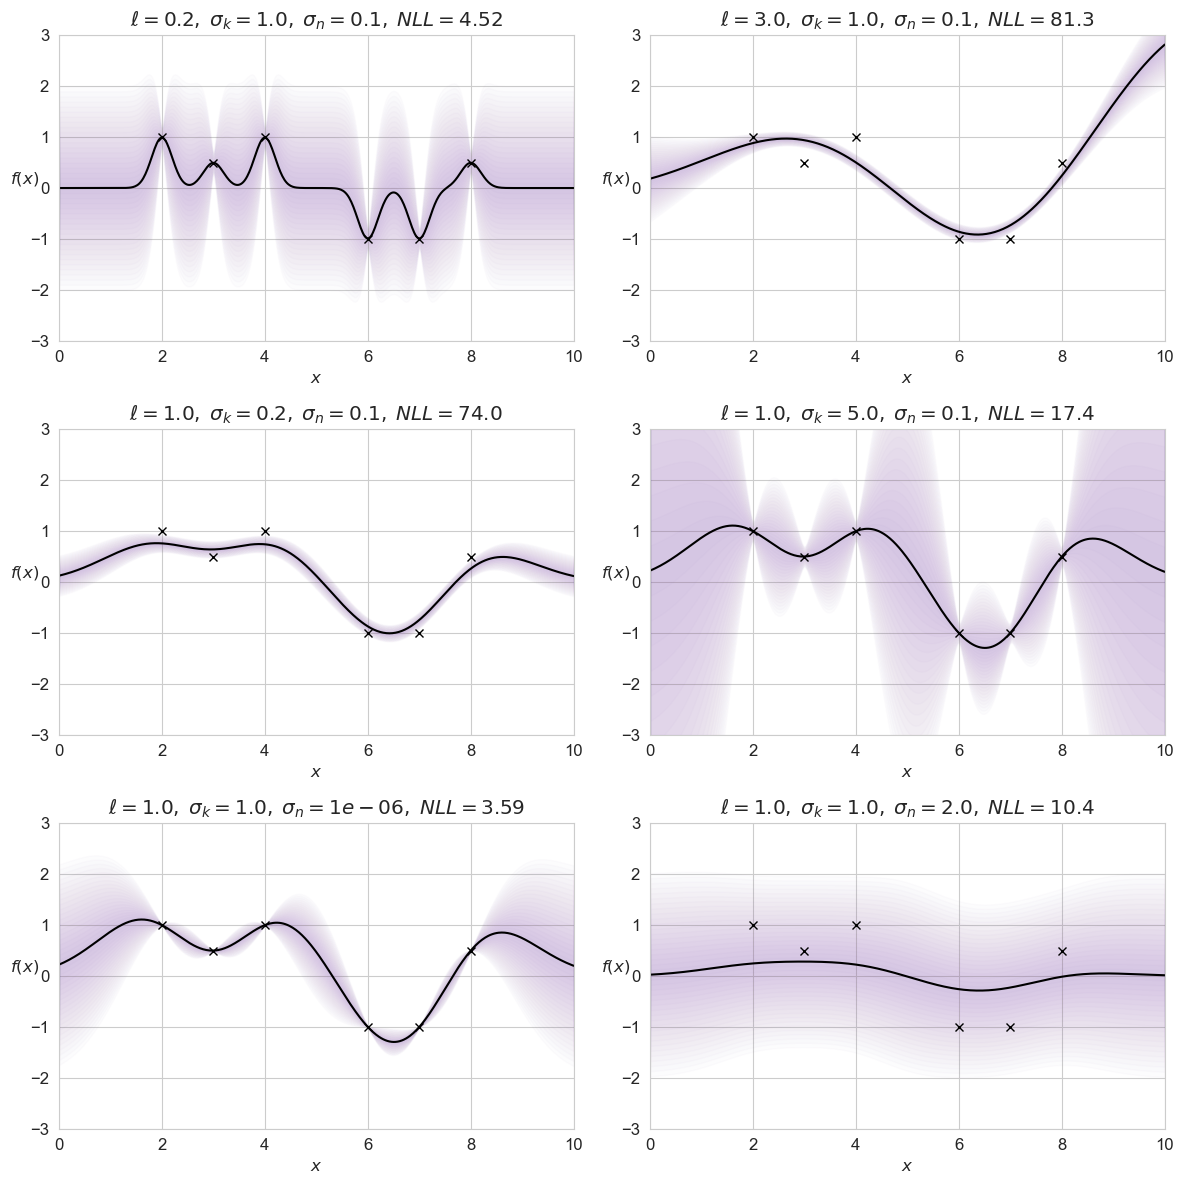

In [15]:
plt.figure(figsize=(12, 12))
y_lim = [-3, 3]

for i, (l, sigma_k, sigma_n) in enumerate(params):
    kernel_fun = GP_kernels.gauss
    kernel_args = {'l':l, 'sigma_k':sigma_k}
    mu, cov = GP_predictor(X_test, X_train, Y_train,
                           kernel_fun, kernel_args, sigma_n)
    nll = nll_fn_1(X_train, Y_train)([l, sigma_k, sigma_n])[0]
    
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(top=2)
    plt.title(f'$\ell = {l},\;\sigma_k = {sigma_k},\;\
                 \sigma_n = {sigma_n},\;NLL = {nll:.3}$')
    plot_GP(X_test, mu, cov, X_train, Y_train, draw_ci=True)
    plt.ylim(y_lim)
    
plt.tight_layout()
plt.show()

In [16]:
res = minimize(nll_fn_1(X_train, Y_train), [1, 1, 1], 
               bounds=((1e-3, None), (1e-3, None), (1e-6, None)),
               method='L-BFGS-B')
l_opt, sigma_k_opt, sigma_n_opt = res.x
[nll] = res.fun

display(Markdown(f'$\ell = {l_opt:.3},\;\sigma_k = {sigma_k_opt:.3},\;\
                    \sigma_n = {sigma_n_opt:.3},\;NLL = {nll:.6}$'))

$\ell = 0.771,\;\sigma_k = 0.858,\;                    \sigma_n = 1e-06,\;NLL = 3.2661$

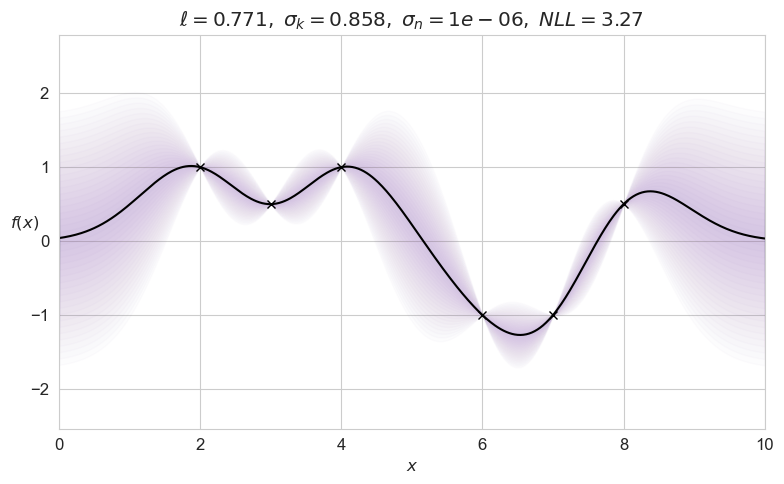

In [17]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
kernel = GP_kernels.gauss
kernel_args = {'l':l_opt, 'sigma_k':sigma_k_opt}
mu, cov = GP_predictor(X_test, X_train, Y_train,
                           kernel, kernel_args, sigma_n_opt)

plt.figure(figsize=(8, 5))
plt.title(f'$\ell = {l_opt:.3},\;\sigma_k = {sigma_k_opt:.3},\;\
             \sigma_n = {sigma_n_opt:.3},\;NLL = {nll:.3}$')
plot_GP(X_test, mu, cov, X_train, Y_train, draw_ci=True)
plt.tight_layout()
plt.show()

Уровень шума минимизировался.
Зафиксируем уровень шума.

In [18]:
def nll_fn(X_train, Y_train, sigma_n):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        sigma_n: known noise level of Y_train
        
    Returns:
        Minimization objective
    '''
    def nll(theta):
        kernel_args = {'l':theta[0], 'sigma_k':theta[1]}
        K = GP_kernels.gauss(X_train, X_train, kernel_args) + \
            sigma_n**2 * np.eye(len(X_train))
        y = Y_train.T @ LA.inv(K) @ Y_train + np.log(LA.det(K))
        return y.flatten()
    
    return nll

In [19]:
sigma_n = 0.1
res = minimize(nll_fn(X_train, Y_train, sigma_n), [1, 1],
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_k_opt = res.x
[nll] = res.fun

display(Markdown(f'$\ell = {l_opt:.3},\;\sigma_k = {sigma_k_opt:.3},\;\
                    \sigma_n = {sigma_n:.3},\;NLL = {nll:.6}$'))

$\ell = 0.778,\;\sigma_k = 0.852,\;                    \sigma_n = 0.1,\;NLL = 3.26679$

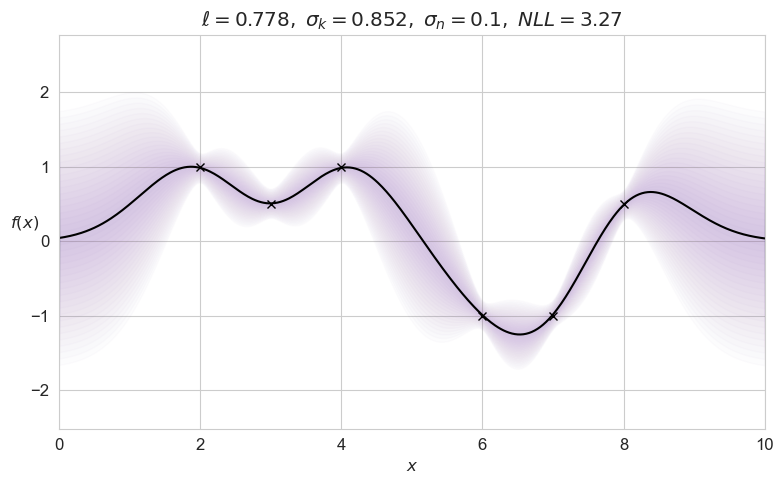

In [20]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
kernel = GP_kernels.gauss
kernel_args = {'l':l_opt, 'sigma_k':sigma_k_opt}
mu_s, cov_s = GP_predictor(X_test, X_train, Y_train,
                           kernel, kernel_args, sigma_n)

plt.figure(figsize=(8, 5))
plt.title(f'$\ell = {l_opt:.3},\;\sigma_k = {sigma_k_opt:.3},\;\
             \sigma_n = {sigma_n:.3},\;NLL = {nll:.3}$')
plot_GP(X_test, mu_s, cov_s, X_train, Y_train, draw_ci=True)
plt.tight_layout()
plt.show()

### Двумерный случай

In [21]:
from mpl_toolkits.mplot3d import Axes3D

def plot_gp_2D(ax, gx, gy, mu, X_train, Y_train, title):
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm,
                    linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

In [22]:
N_train = 100
noise_2D_train = 0.05
sigma_n = 0.05

rx, ry = np.arange(-5, 5, 0.2), np.arange(-5, 5, 0.2)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (N_train, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D_train * np.random.randn(len(X_2D_train))

In [23]:
kernel = GP_kernels.gauss
kernel_args = {'l':1., 'sigma_k':1.}
mu, _ = GP_predictor(X_2D, X_2D_train, Y_2D_train,
                       kernel, kernel_args, sigma_n)

In [24]:
res = minimize(nll_fn(X_2D_train, Y_2D_train, sigma_n), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_k_opt = res.x
kernel_args = {'l':l_opt, 'sigma_k':sigma_k_opt}
mu_opt, _ = GP_predictor(X_2D, X_2D_train, Y_2D_train,
                       kernel, kernel_args, sigma_n)

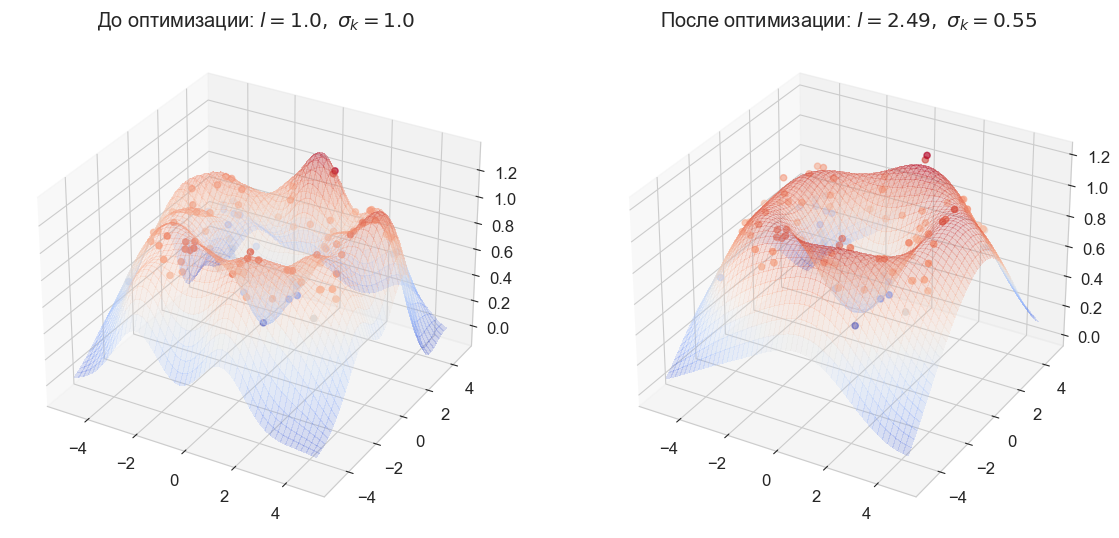

In [25]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, projection='3d')
plot_gp_2D(ax1, gx, gy, mu, X_2D_train, Y_2D_train, 
           f'До оптимизации: $l={1.00},\;\sigma_k={1.00}$')

ax2 = fig.add_subplot(122, projection='3d')
plot_gp_2D(ax2, gx, gy, mu_opt, X_2D_train, Y_2D_train,
           f'После оптимизации: $l={res.x[0]:.2f},\;\sigma_k={res.x[1]:.2f}$')

---

## Источники

1. *Roelants P.* [Understanding Gaussian processes](https://peterroelants.github.io/posts/gaussian-process-tutorial/).
1. *Krasser M.* [Gaussian processes](http://krasserm.github.io/2018/03/19/gaussian-processes/).

In [26]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(seaborn.__version__))

Python: 3.7.16
numpy: 1.20.3
matplotlib: 3.5.1
seaborn: 0.12.2
